# 1. 데이터 불러오기

### 가. 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from dateutil.parser import parse
from tqdm import tqdm

import lightgbm as lgb
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 10)

sns.set(font="Hancom Gothic", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

### 나. 데이터 프레임 변수로 저장
* csv : pd.read_csv("파일이름. csv")
* txt : pd.read_csv("파일이름. csv", sep="구분자")
* xlsx : pd.read_excel('파일이름.xlsx')
* pickle : pd.read_pickle("파일이름.pkl") <br>
 [참고] pickle은 파이썬의 모든 객체를 파일로 저장할 수 있는 방법으로 DataFrame,List,Dict 등 모든 객체 저장 가능(특히 sklearn라이브러리를 통해 모델을 학습시키고, 저장할 때 많이 사용)

In [2]:
train = pd.read_csv("./Data/train.csv").drop( axis=1, columns='SAMPLE_ID')
test = pd.read_csv("./Data/test.csv").drop( axis=1, columns='SAMPLE_ID')
# train.drop('index', axis=1, inplace=True)
train # 데이터 프레임 확인하기

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,10.0,10.0,4820,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,10.0,10.0,1600,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,20.0,10.0,34800,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,10.0,10.0,16900,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


In [5]:
col_dic = {'ARI_CO':'도착국가',
            'ARI_PO':'도착 항구명',
            'SHIP_TYPE_CATEGORY':'5대 선종으로 분류',
            'DIST':'정박지와 접안지 거리(km)',
            'ATA':'실제 정박 시각(H)',
            'ID':'선박식별 일련번호',
            'BREADTH':'선박 폭(m)',
            'BUILT':'선박 연령',
            'DEADWEIGHT':'선박 재화중량톤수(t)',
            'DEPTH':'선박 깊이(m)',
            'DRAUGHT':'흘수 높이(m)',
            'GT':'용적톤수 값',
            'LENGTH':'선박 길이(m)',
            'SHIPMANAGER':'선박 소유주',
            'FLAG':'선박 국적',
            'U_WIND':'풍향 u벡터(m/s)',
            'V_WIND':'풍향 v벡터(m/s)',
            'AIR_TEMPERATURE':'기온(C)',
            'BN':'보퍼트 풍력 계급',
            'ATA_LT':'현지 정박 시각(H)',
            'DUBAI':'해당일의 두바이유 값($)',
            'BRENT':'해당일의 브렌트유 값($)',
            'WTI':'해당일의 WTI 값($)',
            'BDI_ADJ':'조정된 벌크운임지수',
            'PORT_SIZE':'접안지 폴리곤 영역의 크기',
            'CI_HOUR':'대기시간(h)'}

# train = train.rename(columns=col_dic)
# test = test.rename(columns=col_dic)
train
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,10.0,10.0,4820,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,10.0,10.0,1600,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,20.0,10.0,34800,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,10.0,10.0,16900,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


# 2. 데이터 탐색(시각화)

##### 국가에 따라 대기시간이 긴 국가가 있나?
- ##### >>>> 남아프리카, 남미 이쪽은 확실히 대기시간이 길가
- ##### >>>> 비교적 아시아권이 대기시간이 짧다
- ##### >>>> 일 처리 방식, 문화에 따라 다를 수도 있겠음

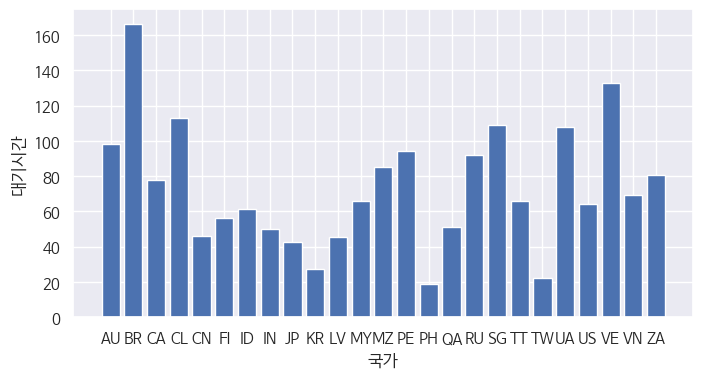

In [6]:
df = train.copy()

# 막대 그래프로 국가별 대기시간 비교
df_nation = df.groupby('ARI_CO').mean()

# 인덱스 리스트로
label = df_nation.index
plt.figure(figsize=(8,4))

# 인덱스를 X, 평균 가격을 Y로 하는 막대 그래프 
plt.bar(label, df_nation['CI_HOUR'])
plt.xlabel('국가')
plt.ylabel('대기시간')
plt.show()

##### 도착 시간에 따른 대기시간 차이가 있나?
- ##### >>>> 현지 기준으로 18시 부터 6시 전에 도착하면 대기시간이 는다는 것을 알 수 있다. 주 근무시간 때문에 그런듯 하다.
- ##### >>>> 몰리는 도착시간이 있나?

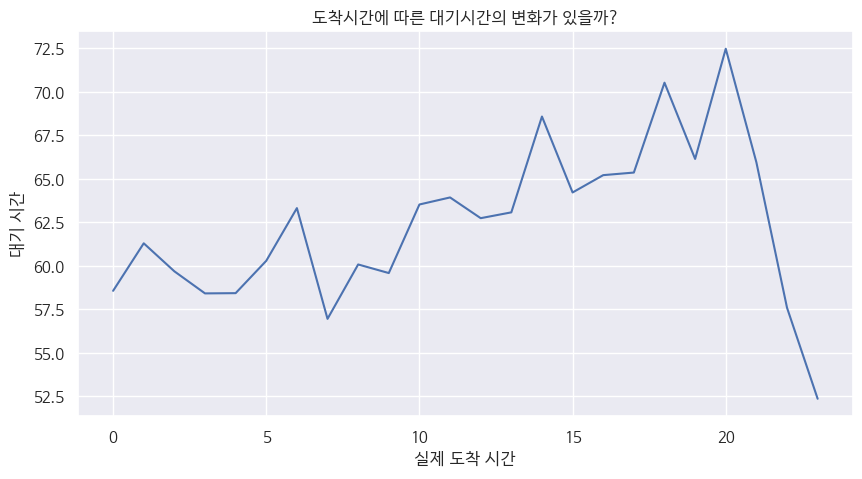

In [9]:
df_temp = df.copy()

df_temp['ATA'] = pd.to_datetime(df_temp['ATA'])

df_temp['ATA_HOUR'] = df_temp['ATA'].apply(lambda x : int(x.strftime('%H')))

df_temp_1 = df_temp.groupby('ATA_HOUR').mean()

# 그래프
plt.figure(figsize=(10,5))

plt.plot(df_temp_1['CI_HOUR'])
plt.xlabel('실제 도착 시간')
plt.ylabel('대기 시간')
plt.title('도착시간에 따른 대기시간의 변화가 있을까?')
plt.show()

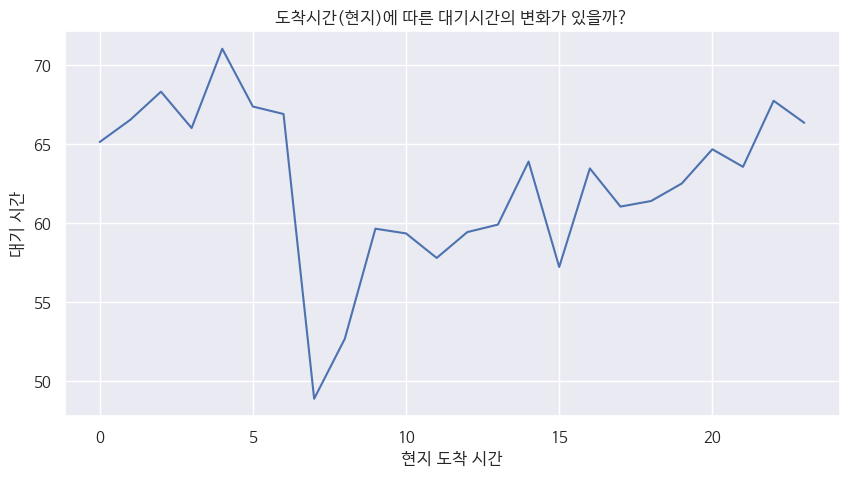

In [10]:
df_temp_2 = df_temp.groupby('ATA_LT').mean()

# 그래프
plt.figure(figsize=(10,5))

plt.plot(df_temp_2['CI_HOUR'])
plt.xlabel('현지 도착 시간')
plt.ylabel('대기 시간')
plt.title('도착시간(현지)에 따른 대기시간의 변화가 있을까?')
plt.show()

In [11]:
df_temp['ATA_HOUR'].value_counts().index.size
df_temp['ATA_HOUR'].value_counts().index

df_temp['CI_HOUR'].mean()

61.9408345927027

##### 몰리는 도착시간이 있나?
- ##### >>>> 그렇지 않음.

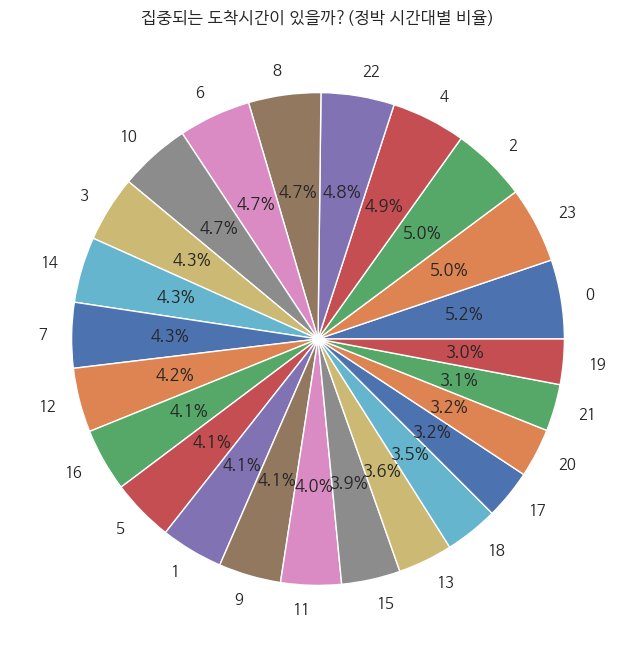

In [12]:

df_temp_1 = df_temp['ATA_HOUR'].value_counts()

# 그래프
plt.figure(figsize=(8,8))

plt.pie(df_temp_1, labels = df_temp_1.index, autopct='%.1f%%')
plt.title('집중되는 도착시간이 있을까?(정박 시간대별 비율)')
plt.show()

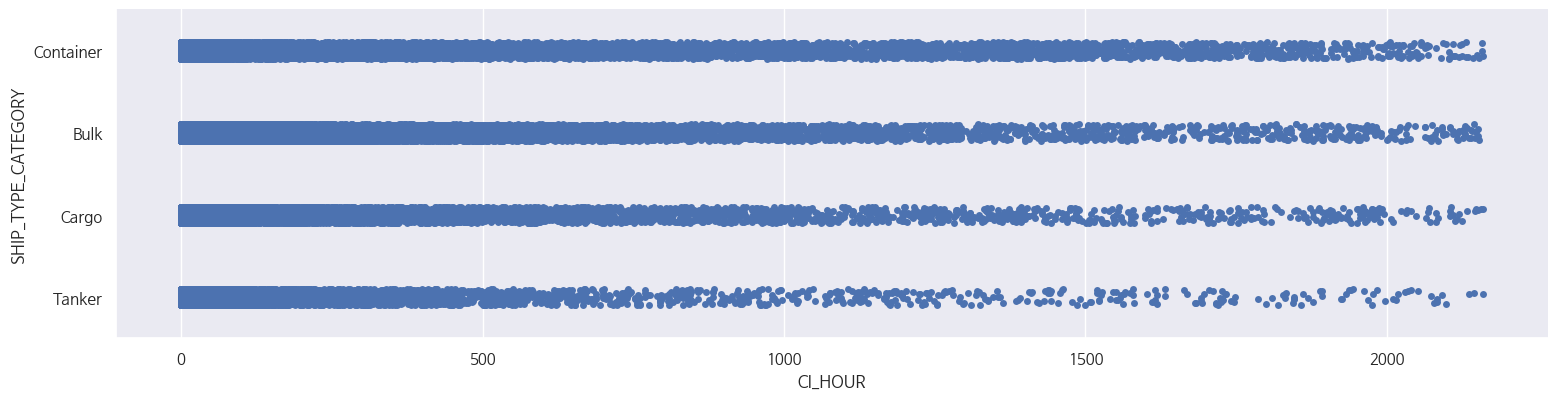

In [14]:
ax = sns.catplot(data=df_temp, x='CI_HOUR', y='SHIP_TYPE_CATEGORY', )
ax.fig.set_size_inches(20,4)
plt.show()

In [15]:
train['CI_HOUR'].describe()


count    391939.000000
mean         61.940835
std         170.809558
min           0.000000
25%           0.000000
50%           7.944444
75%          49.176111
max        2159.130556
Name: CI_HOUR, dtype: float64

# 3. 데이터 전처리

In [16]:
train.describe(include='all')

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,391939,391939,391939,391939.000000,391939,391939,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,391939,391939,228251.000000,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
unique,25,103,4,NaN,336609,25028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6566,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CN,GIW5,Container,NaN,2022-01-31 14:59,E231315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PSPJ35,Panama,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,141743,43865,166315,NaN,56,776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6398,64478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,19.328187,NaN,NaN,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,NaN,NaN,-0.294910,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
std,NaN,NaN,NaN,30.930059,NaN,NaN,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,NaN,NaN,3.366585,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558
min,NaN,NaN,NaN,0.000000,NaN,NaN,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,NaN,NaN,-25.330000,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,NaN,NaN,NaN,0.000000,NaN,NaN,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,NaN,NaN,-2.150000,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,NaN,NaN,NaN,6.929678,NaN,NaN,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,NaN,NaN,-0.130000,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,NaN,NaN,NaN,25.692827,NaN,NaN,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,NaN,NaN,1.540000,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [19]:
train.head(3)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.45
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.00
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.00


### 가. 결측치 확인
- target에 결측지 없음
- 풍향 결측치 : 153486(41%)
- 기온 결측치 : 154365(42%)
- 보퍼트 풍력 계급 : 153486(41%)
- 선박 폭(m) : 1
- 선박 깊이(m) : 1
- 흘수 높이(m) : 1
- 선박 길이(m) : 1

In [20]:
train[train.isna().any(axis=1)].head() #154366 행


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
6,ID,REJ1,Container,42.276281,2016-12-11 3:00,A735263,20.0,30,6800,10.0,10.0,4810,110.0,HCOS27,Indonesia,NaN,NaN,NaN,NaN,10,0.000041,31.700556
8,JP,HYG5,Cargo,0.000000,2015-12-10 2:03,L124642,30.0,12,37200,20.0,10.0,22900,180.0,UOPG57,Panama,NaN,NaN,NaN,NaN,11,0.000256,0.000000


In [21]:
def isNullSum(train):
    nullSum = train[train.isna().any(axis=1)].isnull().sum()
    result = nullSum[nullSum != 0]
    return result

print(isNullSum(train), '\n')
print(isNullSum(test))

BREADTH                 1
DEPTH                   1
DRAUGHT                 1
LENGTH                  1
U_WIND             163688
V_WIND             163688
AIR_TEMPERATURE    164630
BN                 163688
dtype: int64 

U_WIND             91725
V_WIND             91725
AIR_TEMPERATURE    92246
BN                 91725
dtype: int64


In [25]:
(100*163688)/train.shape[0]

41.7636417911971

##### 결측치 처리(fillna)

- 결측치를 채울 수 있지만, 1개의 결측치가 1행에 몰려있어 삭제하는 것이 더 효율적이다.
- 1개의 행을 삭제한다고 해서 30만개의 데이터에 영향을 주지 않기 때문이다.

In [27]:
train[train['BREADTH'].isna()] #일련번호 A457875
train[train['GT'] == 500]['BREADTH'].value_counts() # '용적톤수 값'과 상관관계가 높으므로 10으로 대체
train['BREADTH'] = train['BREADTH'].fillna(10.0)

print(isNullSum(train))
print()
print(isNullSum(test))

DEPTH                   1
DRAUGHT                 1
LENGTH                  1
U_WIND             163688
V_WIND             163688
AIR_TEMPERATURE    164630
BN                 163688
dtype: int64

U_WIND             91725
V_WIND             91725
AIR_TEMPERATURE    92246
BN                 91725
dtype: int64


##### 결측치 처리(drop)

In [30]:
# 삭제
train.dropna(subset = ['DEPTH'], inplace=True)

# 확인
print(isNullSum(train))

U_WIND             163688
V_WIND             163688
AIR_TEMPERATURE    164630
BN                 163688
dtype: int64


##### 결측치가 없을 경우 풍향벡터와 기온, 보퍼트 features 와 target 상관관계 보기
    - 0.05 이하로 상관관계가 없음

<Axes: >

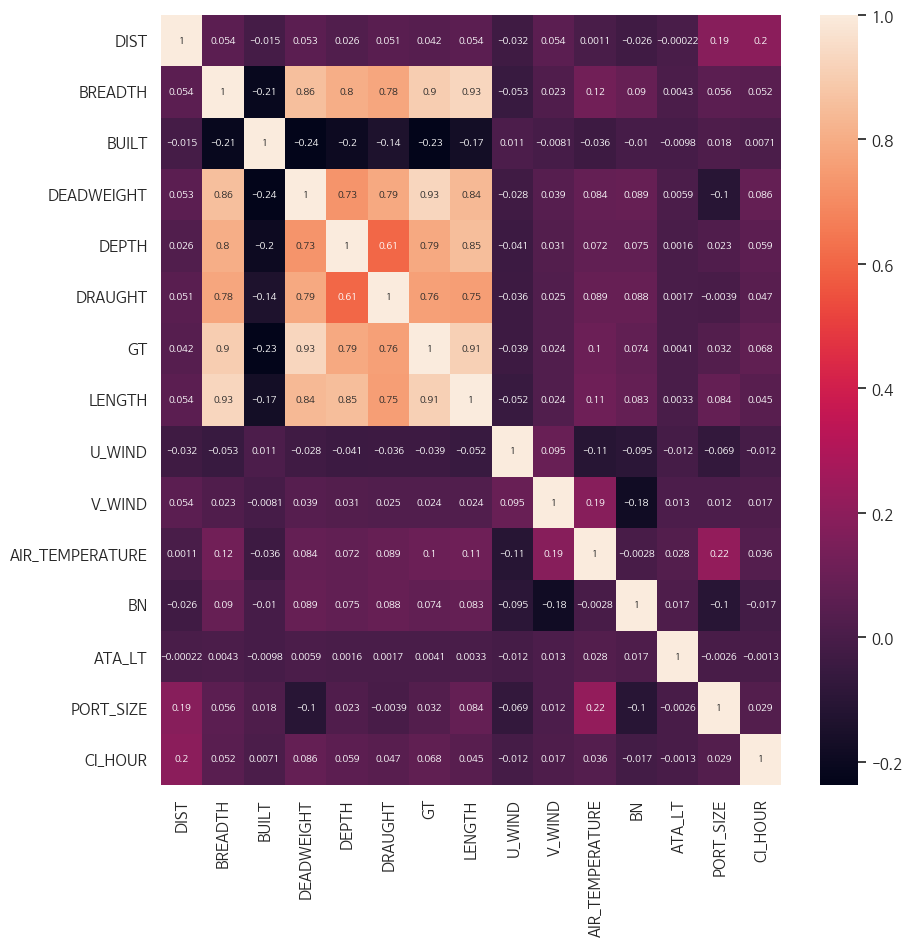

In [31]:
train_corr = train.dropna(axis=0).corr()

sns.heatmap(train_corr, annot = True, annot_kws = {"size" : 7})

##### 결측치 평균값으로 채우기

In [79]:
# 시각 -> datetime으로 타입 변경 해서 정렬한 후 보기


# # train_datetime = train[train.isna().any(axis=1)].sort_values(by=['ATA'], ascending=True).reset_index()
# train_datetime = train.sort_values(by=['ATA'], ascending=True).reset_index()
# train_datetime.describe()

In [33]:
for df in [train, test]:
        dict = {'U_WIND':df['U_WIND'].mean(), 
                'V_WIND': df['V_WIND'].mean(),
                'AIR_TEMPERATURE':df['AIR_TEMPERATURE'].mean(),
                'BN':df['BN'].mean()}

        # 평균 값으로 채우기
        df.fillna(value=dict, inplace=True)

In [34]:
# 결측치 없는 것 확인
print(isNullSum(train))
print(isNullSum(test))

Series([], dtype: float64)
Series([], dtype: float64)


### 나. 이상치 처리
- 이산형 : 선박의 폭(6), 선박의 깊이(4), 흘수 높이(3), 정박시각(24), 접안지폴리곤 영역 크기  
  
- 선박의 연령 : 대부분 60년 이하, 그 이후 값은 삭제해도 무방할 듯  
- 해당일의 WTI값 : 음수인 값은 삭제하거나 전,후일의 값으로 대체
- 해당일 두바이유/ 브렌트유/ WTI 는 유가에 관련된 변수로 서로 상관관계가 높다
- 위 3개의 변수들에 영향을 받틑 벌크운임지수 또한 상관관계를 갖는다.
- 선박의 길기가 길수록 재화중량톤수, 용적 톤수가 높아진다. 
- 재화중량톤수와 용적톤수는 상관관계를 갖는다.

##### 시각적으로 확인

In [82]:
# sns.pairplot(train)
# plt.show()

##### IQR(Inter Quartile Range)로 확인하기

- IQR 기준 이상치 확인하는 합수

In [35]:
def find_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = 1.5 * (Q3 - Q1)
    
    outlier = dataframe[( (dataframe[column] > (Q3 + IQR)) | (dataframe[column] < (Q1 - IQR)) )]
    
    return len(outlier)

- IQR 이상치 대체 함수 만들기

In [36]:
def replace_outliers(train, column):
    Q1 = train[column].quantile(0.25)
    Q3 = train[column].quantile(0.75)
    IQR = 1.5 * (Q3 - Q1)
    
    Min = Q1 - IQR
    Max = Q3 + IQR
    
    train.loc[(train[column] > Max) , column] = Max 
    train.loc[(train[column] < Min) , column] = Min 
    
    return train

In [37]:
# 숫자형 데이터 컬럼만 가져오기
cols = train.select_dtypes(include="number").columns
cols

Index(['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT',
       'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT',
       'PORT_SIZE', 'CI_HOUR'],
      dtype='object')

In [38]:
outliersCols = []
for col in cols:
    result = find_outliers(train, col)
    if result != 0:
        outliersCols.append(col)
        print(col, "이상치 개수 :", result)
        print('------------------------------------------------------')
    
print(outliersCols)

DIST 이상치 개수 : 33820
------------------------------------------------------
BUILT 이상치 개수 : 9872
------------------------------------------------------
DEADWEIGHT 이상치 개수 : 22899
------------------------------------------------------
DRAUGHT 이상치 개수 : 87549
------------------------------------------------------
GT 이상치 개수 : 18288
------------------------------------------------------
U_WIND 이상치 개수 : 138744
------------------------------------------------------
V_WIND 이상치 개수 : 140640
------------------------------------------------------
AIR_TEMPERATURE 이상치 개수 : 71041
------------------------------------------------------
BN 이상치 개수 : 106101
------------------------------------------------------
CI_HOUR 이상치 개수 : 48820
------------------------------------------------------
['DIST', 'BUILT', 'DEADWEIGHT', 'DRAUGHT', 'GT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'CI_HOUR']


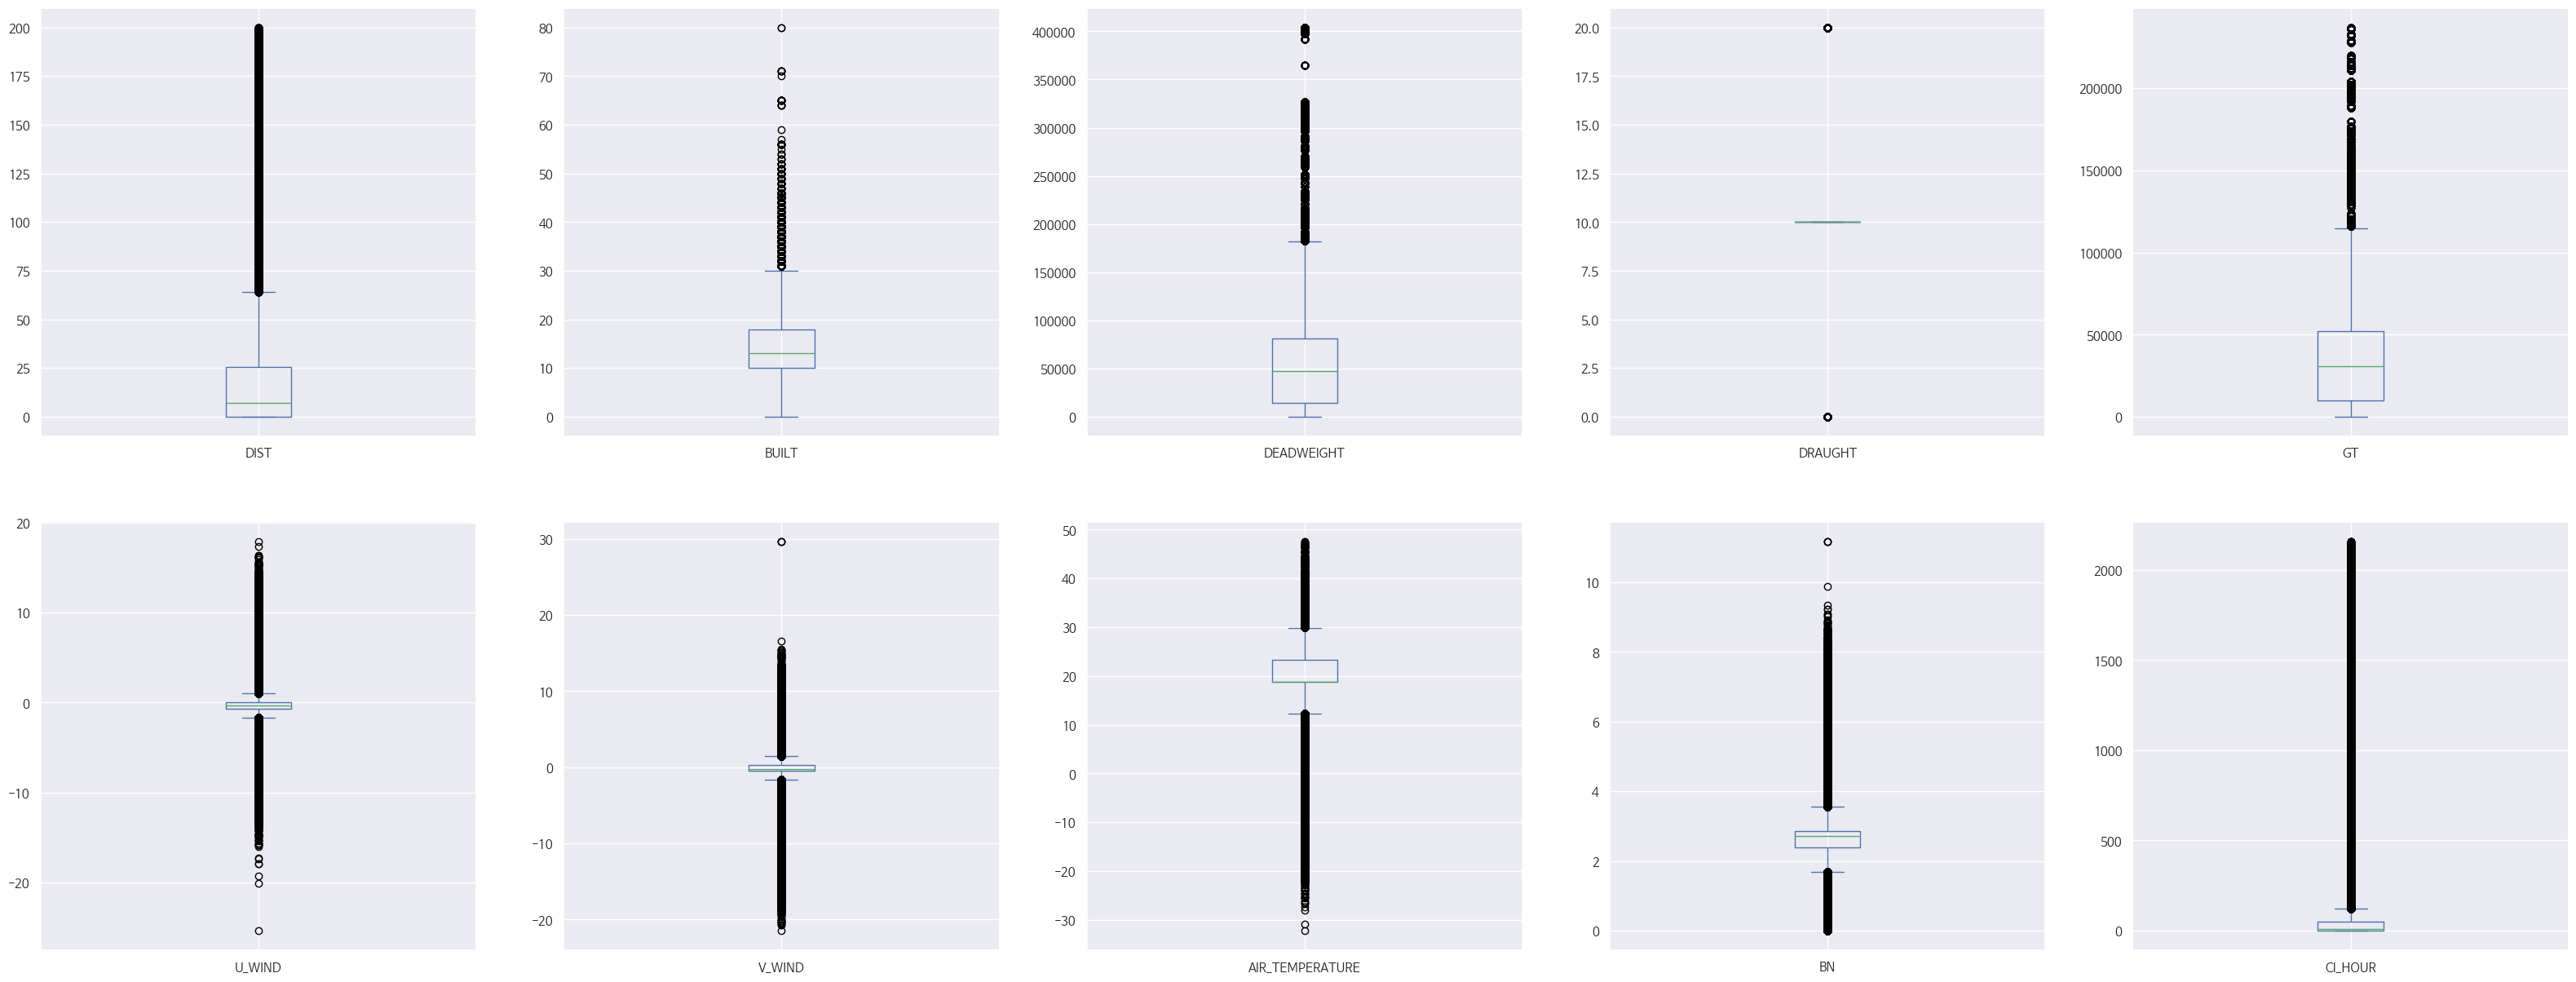

In [46]:
train[outliersCols].plot(kind='box', subplots=True, layout=(2, 5), figsize=(40, 15))
plt.show()

# 이상치가 아닌 것 : '흘수 높이(m)'
# wti에 있는 음수 값 제거하기

##### WTI값이 음수인 행 삭제

In [88]:
# train = train[train['WTI'] >= 0]
# test = test[test['WTI'] >= 0]

In [41]:
# # 확인
# plt.figure(figsize=(3,4))
# train[['WTI']].boxplot()
# plt.ylabel('WTI')

### 다.데이터 타입 변경(날짜 데이터는 DateTime으로)

In [48]:
train['ATA'] = pd.to_datetime(train['ATA'], format='%Y-%m-%d %H:%M')
test['ATA'] = pd.to_datetime(test['ATA'], format='%Y-%m-%d %H:%M')

train['ATA'].head()

0   2018-12-17 21:29:00
1   2014-09-23 06:59:00
2   2015-02-03 22:00:00
3   2020-01-17 04:02:00
4   2020-01-26 07:51:00
Name: ATA, dtype: datetime64[ns]

In [91]:
# train['ATA_HM'] = train['ATA'].apply(lambda x : x.strftime('%H:%M'))
# train['ATA_DATE'] = train['ATA'].apply(lambda x : x.strftime('%Y-%m-%d'))
# train = train.drop(axis=1, columns='ATA')
# train.head()

### 라. 파생변수 생성
#### - datetime을 여러 파생 변수로 변환

In [58]:
# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['YEAR'] = df['ATA'].dt.year
    df['MONTH'] = df['ATA'].dt.month
    df['DAY'] = df['ATA'].dt.day
    df['HOUR'] = df['ATA'].dt.hour
    df['MINUTE'] = df['ATA'].dt.minute
    df['WEEKDAY'] = df['ATA'].dt.weekday

In [59]:
train.head(3)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,SG,GIW5,Container,30.881018,2018-12-17 21:29:00,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,-0.29491,-0.263841,18.86294,2.706997,5,0.002615,3.45,2018,12,17,21,29,0
1,IN,UJM2,Bulk,0.000000,2014-09-23 06:59:00,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,-0.29491,-0.263841,18.86294,2.706997,12,0.000217,0.00,2014,9,23,6,59,1
2,CN,EUC8,Container,0.000000,2015-02-03 22:00:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,-0.29491,-0.263841,18.86294,2.706997,6,0.001614,0.00,2015,2,3,22,0,1


In [60]:
test.head(3)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,SG,GIW5,Container,1.826589,2020-06-18 11:58:00,K322654,50.0,18,117000,30.0,20.0,109000,340.0,KQMD74,Panama,0.37,1.63,27.1,1.587063,19,0.002615,2020,6,18,11,58,3
1,CN,WEY7,Cargo,25.399386,2021-05-26 22:20:00,E376681,10.0,13,3810,10.0,10.0,2560,80.0,LBYS27,Belize,-2.79,-2.33,14.2,2.663972,6,0.001028,2021,5,26,22,20,2
2,CN,NGG6,Container,111.079467,2019-12-16 00:09:00,F811111,20.0,26,10900,10.0,10.0,8440,140.0,EKFV15,Singapore,0.04,-4.91,9.3,3.255315,8,0.001743,2019,12,16,0,9,0


### 마. 데이터 탐색(다시)
##### - "연도에 따른 대기시간 변화가 있을까?"
- ##### >>>> 2014, 2023년은 데이터 수가 적기 때문에 제외
- ##### >>>> 2015~2022년가지 대기시간이 점점 증가하는 추세를 보이고 있다.
- ##### >>>> 코로나, 인터넷 발달로 세계에서 물류량이 늘어난 것으로 보인다.

In [94]:
train['YEAR'] = train['YEAR'].astype('O')

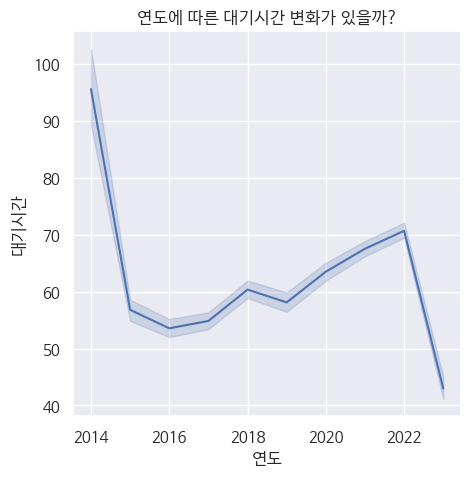

In [62]:
temp = train[['YEAR', 'CI_HOUR']]
temp.groupby('YEAR').mean()

temp[''] = round(temp['CI_HOUR'],2)
temp

plt.figure(figsize=(5,5))
# plt.scatter(x=temp['YEAR'], y=temp['CI_HOUR'])
# sns.lineplot(data=temp, x="YEAR", y='CI_HOUR', hue="MONTH")
sns.lineplot(data=temp, x="YEAR", y='CI_HOUR')
plt.xlabel("연도")
plt.ylabel("대기시간")
plt.title("연도에 따른 대기시간 변화가 있을까?")
plt.show()

In [96]:
train['MONTH'].unique()

array([10,  9,  2,  8,  1,  6, 12,  3,  7, 11,  4,  5], dtype=int64)

##### - "연도/월별 대기시간 변화가 있을까?"

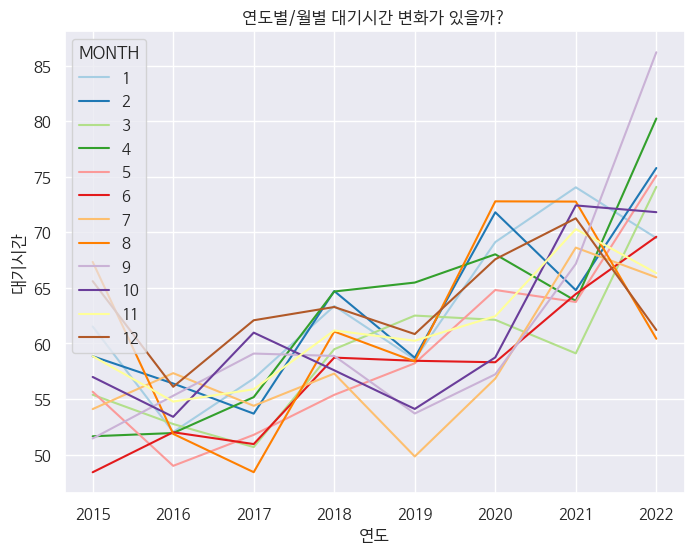

In [63]:
temp = train[['MONTH', 'YEAR', 'CI_HOUR']]
temp['CI_HOUR'] = round(temp['CI_HOUR'],2)

# month가 모두 있지 않은 연도는 제외하고 자세히 보기
temp = temp[(temp.YEAR != 2014)&(temp.YEAR != 2023)]

plt.figure(figsize=(8,6))
sns.lineplot(data=temp, x="YEAR", y='CI_HOUR', hue="MONTH", 
             palette='Paired', legend= "full" , ci=None)
plt.xlabel("연도")
plt.ylabel("대기시간")
plt.title("연도별/월별 대기시간 변화가 있을까?")
plt.show()

### ( 데이터 중간 저장 )

In [64]:
# 데이터 중간 저장

train.to_csv( "./Data/train(신규변수 및 인코딩 전).csv", index=False)

### 바. 신규/파생 변수 생성(나중에 해보기)
#### - '조정된 벌크운임지수'와 '두바이/브렌트/WTI 값' 3개간 연관성이 높다고 판단 -> Linear Regression으로 관계 확인하기

In [99]:
# train['국가-항구명'] = train['ARI_CO] + "-" + train['ARI_PO']
# train.drop(inplace=True, axis=1, columns=['ARI_CO', 'ARI_PO'])

In [65]:
# from sklearn.metrics import r2_score
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# import statsmodels.api as sm

In [66]:
# Oil_BDI = train.loc[: , '해당일의 두바이유 값($)' : '조정된 벌크운임지수']

# x = Oil_BDI.drop('조정된 벌크운임지수', axis=1)
# y = Oil_BDI[['조정된 벌크운임지수']]

# x.head(3)

In [67]:
# result = {'x_Dubai':[], 'x_Brent':[], 'x_WTI':[]}
# keys_name = list(result.keys())


# # 각각의 변수들에 대한 단순선형회귀 적용
# for n in range(3):
#     lr = LinearRegression()
    
#     x_temp = x.iloc[:, n].values.reshape(-1,1)
    
#     X_train, X_test, y_train, y_test = train_test_split(x_temp, y)
    
#     lr.fit(X_train, y_train)
#     print('점수 ', lr.score(X_test,y_test))
    
#     result[keys_name[n]].append(lr.coef_[0][0])
#     result[keys_name[n]].append(lr.intercept_[0])
#     result[keys_name[n]].append(lr.score(X_test,y_test))
#     print(x.columns[n], '회귀계수 :', lr.coef_[0], lr.intercept_)
    
#     line = lr.coef_[0]*x_temp + lr.intercept_
#     plt.figure(figsize=(3,3))
#     plt.scatter(x_temp, y)
#     plt.plot(x_temp, line, color='red')
#     plt.title(f'{x.iloc[:, n].name}')
#     plt.show()

In [103]:
# result 

{'x_Dubai': [15.999769891033422, 301.25252173088984, 0.20545161994989591],
 'x_Brent': [15.526720771528275, 299.1528264349038, 0.19843604634060763],
 'x_WTI': [16.990324258326915, 274.6890090556726, 0.22186981980901865]}

In [104]:
# # 조화평균 함수 만들기
# def find_harmonic_mean(list):
#     r2_sum = 0
#     for r2 in list:
#         r2_sum += (1/r2)
#     result = len(list)/r2_sum
#     return result 

In [105]:
# coefs = [re[0] for re in list(result.values())]
# intercepts = [re[1] for re in list(result.values())]
# r2s = [re[2] for re in list(result.values())]

# print("coef : ", coefs, 
#       "산술평균 : ", sum(coefs)/3, 
#       "조화평균 : ", find_harmonic_mean(coefs))

# print("intercept : ", intercepts, 
#       "산술평균 : ",sum(intercepts)/3, 
#       "조화평균 : ",find_harmonic_mean(intercepts))

# print("r2 : ", r2s, 
#       "산술평균 : ",sum(r2s)/3, 
#       "조화평균 : ",find_harmonic_mean(r2s))


coef :  [15.999769891033422, 15.526720771528275, 16.990324258326915] 산술평균 :  16.172271640296206 조화평균 :  16.149607624498337
intercept :  [301.25252173088984, 299.1528264349038, 274.6890090556726] 산술평균 :  291.69811907382206 조화평균 :  291.18501750406335
r2 :  [0.20545161994989591, 0.19843604634060763, 0.22186981980901865] 산술평균 :  0.20858582869984074 조화평균 :  0.20813271042130044


In [106]:
# # 모든 데이터로 다중선형회귀 사용했을 떄 결과 >> 비슷함

# lr = LinearRegression()
    
# X_train, X_test, y_train, y_test = train_test_split(x, y)
    
# lr.fit(X_train, y_train)

# print('점수 ', lr.score(X_test,y_test))

# print('회귀계수 :', lr.coef_[0], lr.intercept_)

점수  0.3014646708572214
회귀계수 : [  59.44358178 -133.28189237   92.37523239] [615.95801165]


In [107]:
# results = sm.OLS(y, sm.add_constant(x_Dubai)).fit()
# results.summary()

In [108]:
# results = sm.OLS(y, sm.add_constant(x_Brent)).fit()
# results.summary()

In [109]:
# results = sm.OLS(y, sm.add_constant(x_WTI)).fit()
# results.summary()

In [110]:
# r2s, sum(r2s)

([0.20545161994989591, 0.19843604634060763, 0.22186981980901865],
 0.6257574860995222)

In [111]:
# r2s[0]/sum(r2s) + r2s[1]/sum(r2s) + r2s[2]/sum(r2s)

1.0

In [112]:
# train['해당일 원유가격($)'] = train['해당일의 두바이유 값($)']*(r2s[0]/sum(r2s)) + train['해당일의 브렌트유 값($)']*(r2s[1]/sum(r2s)) + train['해당일의 WTI 값($)']*(r2s[2]/sum(r2s))

# train = train.drop(['해당일의 두바이유 값($)', '해당일의 브렌트유 값($)', '해당일의 WTI 값($)'], axis=1)

# train.head(3)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,대기시간(h),year,month,day,hour,minute,weekday,해당일 원유가격($)
0,CN,EKP8,Bulk,30.736578,2020-10-15 04:03:00,Z517571,30.0,28,73100,20.0,10.0,38600,220.0,CHMT36,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,1407.668330,0.001660,3.048333,2020,10,15,4,3,3,42.002390
1,CN,EUC8,Container,63.220425,2019-09-17 02:55:00,U467618,30.0,15,37900,20.0,10.0,28100,220.0,CUFV52,Singapore,-3.16,-6.72,24.5,4.289058,10,2089.046774,0.001614,17.138611,2019,9,17,2,55,1,63.681140
2,CN,NGG6,Container,90.427421,2019-02-23 06:43:00,V378315,50.0,7,115000,20.0,10.0,96400,300.0,ISIG88,Liberia,0.00,0.00,9.4,0.000000,14,603.193047,0.001743,98.827500,2019,2,23,6,43,5,62.681515


### 사. 필요 없는 컬럼 삭제하기
- 'SAMPLE_ID' : 인덱스 같은 것, 필요 없음
- '선박식별 일련번호' : 선박을 구분하기 위한 번호로 삭제해도 될 것으로 판단
    * 식별번호의 앞 글자가 영향을 주는지는 비교해봐야 할 듯
- '선박 소유주' : 대기시간과 무관
- '선박 국적' : 국가에 따른 협약 등이 작용하는지 모르겠음
- '선박 연령' : 선박이 오래될수록 대기시간이 짧을까?

In [68]:
train = train.drop(axis=1, columns=['ATA'])
test = test.drop(axis=1, columns=['ATA'])

In [69]:
train.head(3)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,SG,GIW5,Container,30.881018,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,-0.29491,-0.263841,18.86294,2.706997,5,0.002615,3.45,2018,12,17,21,29,0
1,IN,UJM2,Bulk,0.000000,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,-0.29491,-0.263841,18.86294,2.706997,12,0.000217,0.00,2014,9,23,6,59,1
2,CN,EUC8,Container,0.000000,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,-0.29491,-0.263841,18.86294,2.706997,6,0.001614,0.00,2015,2,3,22,0,1


In [70]:
test.head(3)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,SG,GIW5,Container,1.826589,K322654,50.0,18,117000,30.0,20.0,109000,340.0,KQMD74,Panama,0.37,1.63,27.1,1.587063,19,0.002615,2020,6,18,11,58,3
1,CN,WEY7,Cargo,25.399386,E376681,10.0,13,3810,10.0,10.0,2560,80.0,LBYS27,Belize,-2.79,-2.33,14.2,2.663972,6,0.001028,2021,5,26,22,20,2
2,CN,NGG6,Container,111.079467,F811111,20.0,26,10900,10.0,10.0,8440,140.0,EKFV15,Singapore,0.04,-4.91,9.3,3.255315,8,0.001743,2019,12,16,0,9,0


### 아. Categorical 컬럼 인코딩

In [71]:
categorical_features =  ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


In [72]:
train.head(3)


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,17,21,2,30.881018,24709,30.0,24,24300,10.0,10.0,16700,180.0,686,89,-0.29491,-0.263841,18.86294,2.706997,5,0.002615,3.45,2018,12,17,21,29,0
1,7,81,0,0.000000,23139,30.0,13,35900,10.0,10.0,23500,180.0,4719,74,-0.29491,-0.263841,18.86294,2.706997,12,0.000217,0.00,2014,9,23,6,59,1
2,4,14,2,0.000000,19008,50.0,12,146000,30.0,20.0,140000,370.0,1370,73,-0.29491,-0.263841,18.86294,2.706997,6,0.001614,0.00,2015,2,3,22,0,1


In [73]:
test.head(3)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,18,22,3,1.826589,9788,50.0,18,117000,30.0,20.0,109000,340.0,2688,90,0.37,1.63,27.1,1.587063,19,0.002615,2020,6,18,11,58,3
1,5,91,2,25.399386,4184,10.0,13,3810,10.0,10.0,2560,80.0,2796,11,-2.79,-2.33,14.2,2.663972,6,0.001028,2021,5,26,22,20,2
2,5,46,3,111.079467,5578,20.0,26,10900,10.0,10.0,8440,140.0,1116,103,0.04,-4.91,9.3,3.255315,8,0.001743,2019,12,16,0,9,0


### ( 데이터 중간 저장 )

In [74]:
# 데이터 중간 저장

train.to_csv( "./Data/train(인코딩 후).csv", index=False)
test.to_csv( "./Data/test(인코딩 후).csv", index=False)

-----

In [75]:
X = train.drop('CI_HOUR', axis=1)
y = train['CI_HOUR']

In [76]:
X_copy = X.copy()
X_copy = X_copy.iloc[:500, :]
X_copy = X_copy.astype('float32')

In [77]:
X_centered = X_copy - X_copy.mean(axis=0)

# 모든 주성분 구하기
U,s,Vt = np.linalg.svd(X_centered)

# PC를 구성하는 3개의 단위벡터 추출
for n in range(3):
    globals()[f'PC_com{n}'] = Vt.T[:, n]

# # 확인
# for n in range(3):
#     print(globals()[f'PC_com{n}'])

s*s / (3-1)


array([1.19375449e+12, 3.98076191e+10, 1.27092541e+10, 8.28107776e+08,
       2.35446156e+05, 2.15343250e+05, 1.94684422e+05, 1.55133406e+05,
       8.62534531e+04, 1.83295840e+04, 1.56728252e+04, 1.32832568e+04,
       1.06742314e+04, 9.01252930e+03, 6.82270410e+03, 3.48660791e+03,
       2.78275122e+03, 2.60439575e+03, 2.38110327e+03, 1.59115613e+03,
       1.41763342e+03, 1.09057275e+03, 7.62973877e+02, 2.53842712e+02,
       1.19911285e+02, 8.90394804e-05], dtype=float32)

In [ ]:
# 사이킷런 사용
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X2D = pca.fit_transform(X_copy)

print("설명된 분산의 비율 : ", pca.explained_variance_ratio_)

# 주성분을 구성하는 단위벡터 3개 확인
for n in range(3):
    # print(pca.components_.T[:, n])
    print(pca.components_.T[:, n])


설명된 분산의 비율 :  [0.9547124  0.03471511 0.00987538]
[-2.1636146e-05  3.3186512e-05 -5.1210181e-06 -1.3416591e-05
 -2.4811646e-03  1.3312497e-04 -2.8191907e-05  8.5132515e-01
  6.6302746e-05  5.3539490e-05  5.2462560e-01  9.3971868e-04
  2.0387759e-03  4.7556827e-05  8.8245918e-07  1.1253200e-06
  3.2462804e-06  2.0450027e-07  3.4785259e-07 -3.2089662e-05
 -3.2560889e-05 -3.4276261e-05 -1.5529924e-03 -1.1509748e-09
 -6.3849679e-06 -2.0026566e-06 -9.9381350e-06 -7.1497539e-06
 -9.9387362e-06 -8.6756074e-07]
[ 9.01673266e-05 -4.79595241e-04  4.06191757e-05 -1.17272175e-04
  4.49714810e-02  1.64416764e-04 -7.46044498e-06 -5.24002612e-01
  1.13006783e-04 -1.21146923e-05  8.50516737e-01  1.65775220e-03
  3.40734469e-03  3.70429552e-05 -2.14301622e-06 -5.76170760e-06
  1.58729090e-05  9.20465482e-06  9.92010337e-06  2.82354849e-05
  4.39171599e-05  4.98839254e-05  2.10877275e-03  2.32943567e-08
  2.51613596e-06 -4.29802128e-07  3.52682764e-05  2.10209619e-05
  2.21129199e-06 -6.90446450e-06]
[-8

### 라. [소개] 요인분석(FactorAnalyzer)
#### 다중공선성의 문제를 해결할 다른 방법은 무엇이 있을까? A: 변수를 변형시키거나 새로운 관측치를 이용
##### 요인분석이란 변수들 사이에서 잠재된 변수를 찾는 과정입니다. 이해를 위해 조금 거칠게 표현하면 드라마 선호도를 확인할 때 로멘스. 휴머니티, 범죄/스릴러, 정치, SF, 판타지 6가지로 조사한다면 내면에는 감성적(로맨스, 휴머니티), 이성적(범죄/스릴러, 정치), 창의적(SF, 판타지) 3가지 잠재적 요소의 영향을 확인하는 과정이라고 할 수 있습니다.
##### 요인분석을 통해 우리는 변수를 축소할 수 있고 잠재된 요소를 확인 할 수 있으나, 반드시 좋은 결과를 담보하는 것은 아니니 입체적으로 바라보고 적용해야 합니다.(일반적으로 크론바흐 계수 0.7이상에서 용인)

##### 1) 라이브러리 Import

In [78]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

##### 2) Kaiser-Meyer-Olkin (KMO) 검정 : 요인 분석을위한 데이터의 적합성을 측정(0.6 미만의 KMO 값은 부적절한 것으로 간주)

In [79]:
# 요인분석은 수치형변수(int, float 등)으로만 이루어진 데이터에서 가능함으로 문자형 변수는 제거 필요

In [80]:
kmo_all,kmo_model=calculate_kmo(X_copy)
kmo_model # 0.642878086837649 : 0.6 이상으로 양호함

0.7947902176013223

##### 3) ScreePlot을 활용한 요인수 결정 : Elbow 기법
* 고유값(각각의 요인으로 설명할 수 있는 변수들의 분산 총합) 시각화

In [81]:
# 요인분석 오브젝트를 만들고 실행해보겠습니다.
fa = FactorAnalyzer()
fa.set_params(rotation=None)
fa.fit(X_copy)
# 고유값 확인 * 고유값(eigenvalue):각각의 요인으로 설명할 수 있는 변수들의 분산 총합
ev, v = fa.get_eigenvalues()
ev

array([5.46240003, 2.32722576, 1.62507852, 1.47880569, 1.31870683,
       1.22146672, 1.15135193, 1.07622214, 1.05956827, 0.98499741,
       0.92402576, 0.86636053, 0.84985454, 0.82083431, 0.74702107,
       0.71156987, 0.66969821, 0.63148967, 0.51853614, 0.44795233,
       0.38558106, 0.34515219, 0.17552091, 0.11467419, 0.05541276,
       0.03049312])

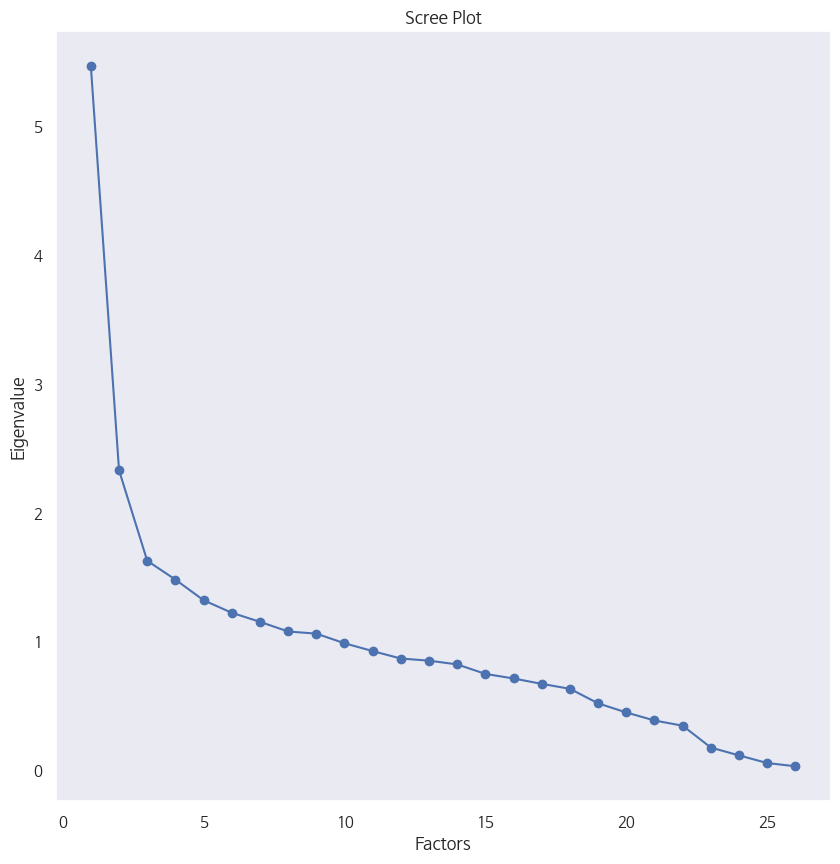

In [82]:
# Scree Plot을 그려서 Elbow 지점을 찾아봅시다.
plt.scatter(range(1,X_copy.shape[1]+1),ev)
plt.plot(range(1,X_copy.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

##### 4) 요인부하량 확인 및 시각화

In [83]:
# 요인분석 오브젝트를 만들고 실행해보겠습니다.
fa = FactorAnalyzer(method='principal', n_factors=9, rotation=None)
fa.fit(X_copy)
(pd.DataFrame(fa.loadings_) >= 0.4).sum() # 요인부하량 확인 : 0.4이상 유의미, 0.5이상 중요

0    6
1    3
2    2
3    3
4    2
5    1
6    2
7    0
8    0
dtype: int64

In [84]:
feature_names = list(X_copy.columns)
fa_result = pd.DataFrame(fa.loadings_, index=feature_names)

<Axes: >

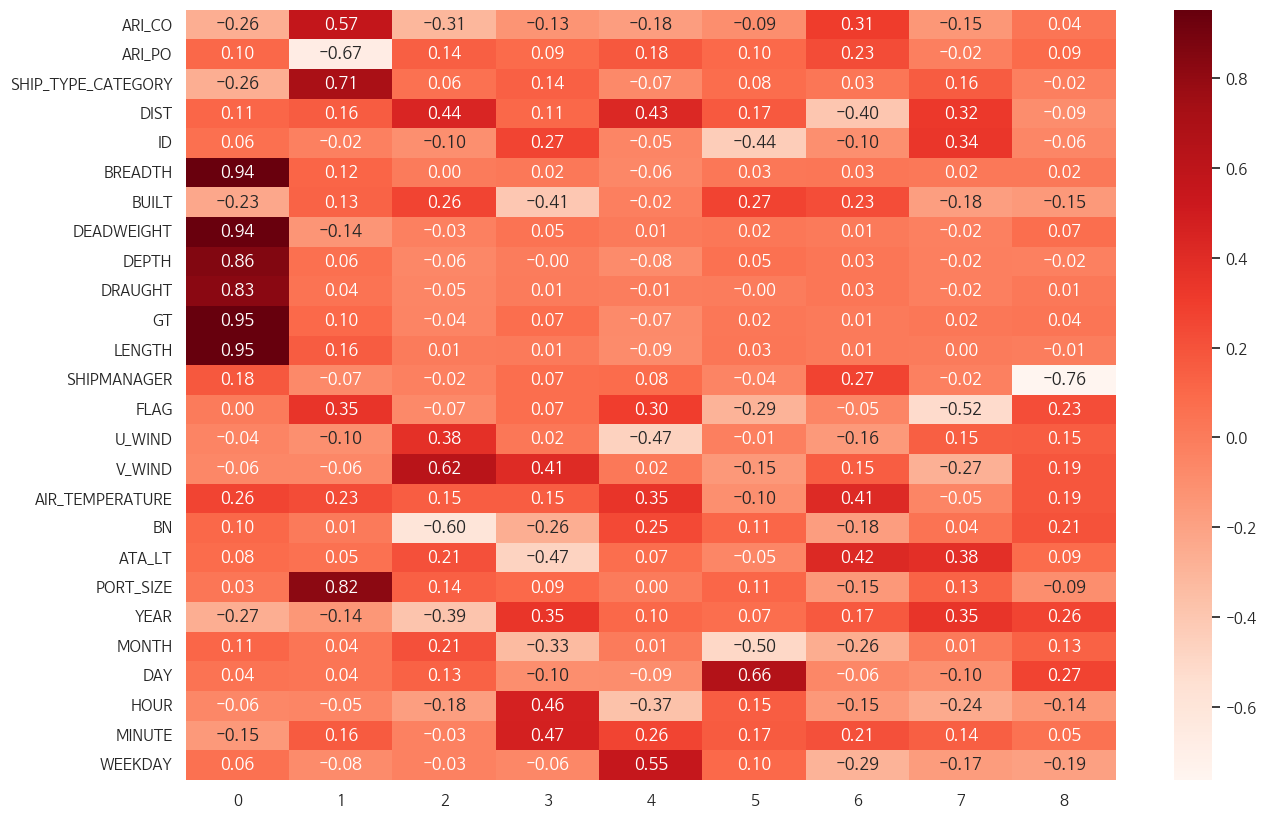

In [85]:
# Heat Map으로 그려서 확인해보겠습니다.
plt.figure(figsize=(15,10))
sns.heatmap(fa_result, cmap="Reds", annot=True, fmt='.2f', )

In [86]:
pd.DataFrame(data=fa.get_factor_variance(), index=['SS Loadings', 'Proportion Var', 'Cumulative Var'], columns=[f'factor{n}' for n in range(fa.n_factors)])

,factor0,factor1,factor2,factor3,factor4,factor5,factor6,factor7,factor8
SS Loadings,5.462400,2.327226,1.625078,1.478801,1.318706,1.221454,1.151350,1.076165,1.059555
Proportion Var,0.210092,0.089509,0.062503,0.056877,0.050719,0.046979,0.044283,0.041391,0.040752
Cumulative Var,0.210092,0.299601,0.362104,0.418981,0.469700,0.516679,0.560962,0.602353,0.643105


In [87]:
fa

FactorAnalyzer(method='principal', n_factors=9, rotation=None,
               rotation_kwargs={})

##### 5) 크론바흐 계수(신뢰도) 계산 : 0.8이상 양호

In [88]:
# 크론바흐 계수를 계산하는 함수를 선언하겠습니다.
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [89]:
X_copy_y = X_copy.copy() 
X_copy_y['y'] = y

In [90]:
# # ET와 ETA 신뢰계수
# print(CronbachAlpha(X_copy_y[['해당일의 브렌트유 값($)', 'y']]))

In [91]:
# # ET와 ETAA 신뢰계수
# print(CronbachAlpha(train[['ET','A_DISTANCE']]))

##### 6) 요인점수를 활용한 변수 생성

In [92]:
X_copy

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,17.0,21.0,2.0,30.881018,24709.0,30.0,24.0,24300.0,10.0,10.0,16700.0,180.0,686.0,89.0,-0.29491,-0.263841,18.862940,2.706997,5.0,0.002615,2018.0,12.0,17.0,21.0,29.0,0.0
1,7.0,81.0,0.0,0.000000,23139.0,30.0,13.0,35900.0,10.0,10.0,23500.0,180.0,4719.0,74.0,-0.29491,-0.263841,18.862940,2.706997,12.0,0.000217,2014.0,9.0,23.0,6.0,59.0,1.0
2,4.0,14.0,2.0,0.000000,19008.0,50.0,12.0,146000.0,30.0,20.0,140000.0,370.0,1370.0,73.0,-0.29491,-0.263841,18.862940,2.706997,6.0,0.001614,2015.0,2.0,3.0,22.0,0.0,1.0
3,8.0,101.0,2.0,0.000000,24047.0,20.0,18.0,6910.0,10.0,10.0,5400.0,120.0,3808.0,5.0,-3.18000,-1.610000,6.700000,2.629350,13.0,0.000356,2020.0,1.0,17.0,4.0,2.0,4.0
4,17.0,21.0,2.0,27.037651,910.0,50.0,10.0,116000.0,20.0,10.0,96600.0,300.0,1687.0,67.0,-0.33000,-3.280000,25.600000,2.495953,15.0,0.002615,2020.0,1.0,26.0,7.0,51.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,98.0,0.0,16.837545,15360.0,40.0,12.0,179000.0,20.0,20.0,92900.0,290.0,2001.0,50.0,-3.98000,-2.510000,26.900000,3.164159,20.0,0.000026,2020.0,5.0,17.0,10.0,16.0,6.0
496,4.0,13.0,0.0,69.822815,23890.0,30.0,22.0,46800.0,20.0,10.0,26200.0,180.0,272.0,20.0,-0.28000,-7.310000,16.200001,4.246387,4.0,0.001660,2020.0,9.0,10.0,20.0,36.0,3.0
497,4.0,34.0,0.0,16.808567,12876.0,30.0,10.0,76400.0,20.0,10.0,41800.0,220.0,4685.0,20.0,6.06000,-6.090000,4.200000,4.726840,2.0,0.000557,2020.0,2.0,22.0,18.0,52.0,5.0
498,4.0,4.0,0.0,36.419933,16723.0,30.0,18.0,82900.0,20.0,10.0,42900.0,230.0,5134.0,74.0,-4.25000,2.460000,25.900000,3.255513,8.0,0.000577,2020.0,8.0,8.0,0.0,40.0,5.0


In [93]:
fa.transform(X_copy)

array([[-0.62095291,  1.82590421,  0.28215849, ..., -1.1216881 ,
        -0.34988367,  0.69060719],
       [-0.17559002, -0.78583285,  0.58482659, ...,  0.53301188,
        -0.35720467, -0.26157967],
       [ 2.07958832,  1.01122398, -0.43509581, ..., -0.90109411,
        -0.81678308, -0.3480266 ],
       ...,
       [ 0.15405192, -1.09714684, -1.60536395, ..., -2.0523632 ,
         0.94800355, -1.15059401],
       [ 0.35673304, -0.01060653,  0.03173982, ...,  0.0179549 ,
        -0.22737813, -0.83353284],
       [ 0.10637328, -0.41540133,  0.18280306, ..., -0.11567987,
        -0.4821601 ,  0.14671557]])